In [1]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.1', 'qiskit-aer': '0.8.1', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.12.2', 'qiskit-aqua': '0.9.1', 'qiskit': '0.25.1', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS, SGD,Adam 

from qiskit  import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.opflow import AerPauliExpectation
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN, TwoLayerQNN
from qiskit_machine_learning.connectors import TorchConnector

import torch.optim as optim
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss,
                     MaxPool2d, Flatten, Sequential, ReLU)

qi = QuantumInstance(Aer.get_backend('statevector_simulator'))

In [3]:
import torch
torch.cuda.is_available()

True

# Data Test 0

In [4]:
import numpy as np
from numpy import pi
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.nn import (Module, Conv2d, Linear, Dropout2d, NLLLoss,
                     MaxPool2d, Flatten, Sequential, ReLU)

data0Path = r'../../dataset/data0test.txt'
data0Label = r'../../dataset/data0testlabel.txt'

dataCoords = np.loadtxt(data0Path)
dataLabels = np.loadtxt(data0Label)

# Make a data structure which is easier to work with
# for shuffling. 
# Also, notice we change the data labels from {0, 1} to {-1, +1}
data1 = list(zip(dataCoords, 2*dataLabels-1))

In [5]:
from pandas.core.common import flatten
import torch

np.random.seed(2)
#data_ixs = np.random.choice(len(shuffled_data), size=len(shuffled_data))
data_ixs = np.random.choice(len(data1), size=100)

X= [np.array(list(flatten([data1[j][0],data1[j][0]]))) for j in data_ixs]
y = [data1[j][1] for j in data_ixs]
y01 =  [ (x + 1)/2 for x in y]
X_ = Tensor(X)
y_ = Tensor(y).reshape(len(y), 1)
y01_ = Tensor(y01).reshape(len(y)).long()

num_inputs=4;
apram=2.0*pi
feature_map = QuantumCircuit(4, name='Embed')
feature_map.rx(apram*Parameter('x[0]'),0)
feature_map.rx(apram*Parameter('x[1]'),1)
feature_map.rx(apram*Parameter('x[2]'),2)
feature_map.rx(apram*Parameter('x[3]'),3)
feature_map.ry(pi/4,0)
feature_map.ry(pi/4,1)
feature_map.ry(pi/4,2)
feature_map.ry(pi/4,3)
feature_map.rz(pi/4,0)
feature_map.rz(pi/4,1)
feature_map.rz(pi/4,2)
feature_map.rz(pi/4,3)


param_y=[];
for i in range(12):
    param_y.append((Parameter('θ'+str(i))))
ansatz = QuantumCircuit(4, name='PQC')
for i in range(4):
    ansatz.ry(param_y[i],i)
for i in range(4):
    ansatz.rz(param_y[i+4],i)
ansatz.cx(0,1)
ansatz.cx(2,3)
ansatz.ry(param_y[8],1)
ansatz.ry(param_y[9],2)
ansatz.rz(param_y[10],1)
ansatz.rz(param_y[11],2)
ansatz.cx(1,2)





qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))

parity = lambda x: firsttwo(binary(x)).count('1') % 2
output_shape = 2  

qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.3*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)

In [6]:
def binary(x):
    return ('0'*(4-len('{:b}'.format(x) ))+'{:b}'.format(x))
def firsttwo(x):
    return x[:2]
parity = lambda x: firsttwo(binary(x)).count('1') % 2

In [7]:
# define optimizer and loss function
optimizer = LBFGS(model2.parameters())
f_loss = MSELoss(reduction='sum')

# start training
model2.train()   # set model to training mode

# define objective function
def closure():
    optimizer.zero_grad()        # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        targets=Tensor([y_target]).long()
        targets = targets.to(torch.float32)
        loss += f_loss(output, targets) 
    loss.backward()                              # backward pass
    print(loss.item())                           # print loss
    return loss

# run optimizer
optimizer.step(closure)

C:\Users\Saesun Kim\AppData\Roaming\Python\Python38\site-packages\torch\nn\modules\loss.py:445: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


51.2056999206543
51.210609436035156
50.50263977050781
50.35367965698242
50.2237548828125
50.122314453125
50.1032829284668
50.09242248535156
50.08271789550781
50.078460693359375
50.075164794921875
50.07421112060547
50.073753356933594
50.07362747192383
50.073646545410156
50.073612213134766
50.0736083984375
50.073585510253906
50.07358169555664
50.073577880859375


tensor(51.2057, grad_fn=<AddBackward0>)

Accuracy: 0.38


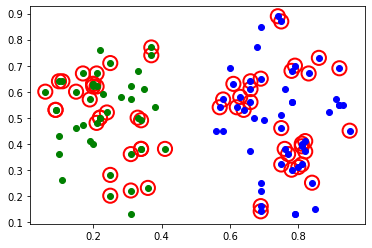

In [8]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

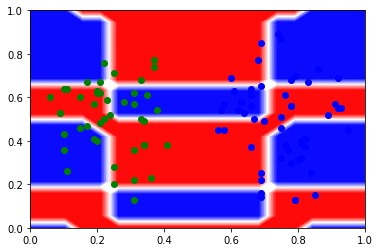

In [9]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=20)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

In [10]:
qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.3*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)

# define optimizer and loss function
optimizer = optim.SGD(model2.parameters(),lr=1)
f_loss = MSELoss(reduction='sum')

# start training
model2.train()   # set model to training mode
epochs = 50     # set number of epochs

# define objective function
for epoch in range(epochs):
    optimizer.zero_grad()        # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        targets=Tensor([y_target]).long()
        targets = targets.to(torch.float32)
        loss += f_loss(output, targets) 
    loss.backward()                              # backward pass
    print(loss.item())                           # print loss

    # run optimizer
    optimizer.step()


50.79498291015625
63.838539123535156
55.0047607421875
50.1397590637207
50.383113861083984
50.16985321044922
50.10130310058594
50.02317428588867
50.00546646118164
50.00352096557617
50.002662658691406
50.002105712890625
50.001708984375
50.00142288208008
50.00120162963867
50.00101852416992
50.00086975097656
50.00075149536133
50.00065231323242
50.00056838989258
50.0004997253418
50.00044250488281
50.0003776550293
50.00033187866211
50.00028610229492
50.00025177001953
50.00021743774414
50.00019454956055
50.00016784667969
50.000152587890625
50.00012969970703
50.00010681152344
50.00009536743164
50.00008773803711
50.00006866455078
50.000057220458984
50.000057220458984
50.00004577636719
50.00004196166992
50.00003433227539
50.00002670288086
50.00002670288086
50.00001907348633
50.00000762939453
50.00000762939453
50.00000762939453
50.00000762939453
50.00000762939453
50.000003814697266
50.000003814697266


Accuracy: 0.57


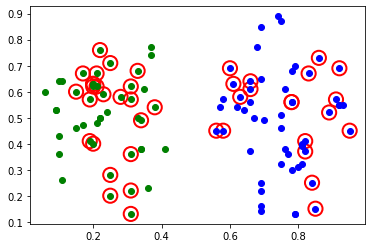

In [11]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

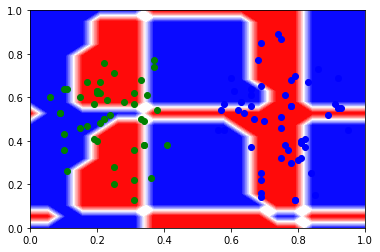

In [12]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=20)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)

In [13]:
qnn2 = CircuitQNN(qc, input_params=feature_map.parameters, weight_params=ansatz.parameters, 
                  interpret=parity, output_shape=output_shape, quantum_instance=qi)

# set up PyTorch module
initial_weights = 0.3*(2*np.random.rand(qnn2.num_weights) - 1)
model2 = TorchConnector(qnn2, initial_weights)


# define optimizer and loss function
optimizer = optim.Adam(model2.parameters(), lr=0.1)
f_loss = MSELoss(reduction='sum')

# start training
model2.train()   # set model to training mode
epochs = 100     # set number of epochs

# define objective function
for epoch in range(epochs):
    optimizer.zero_grad()        # initialize gradient
    loss = 0.0                                             # initialize loss    
    for x, y_target in zip(X, y01):                        # evaluate batch loss
        output = model2(Tensor(x)).reshape(1, 2)           # forward pass
        targets=Tensor([y_target]).long()
        targets = targets.to(torch.float32)
        loss += f_loss(output, targets) 
    loss.backward()                              # backward pass
    print(loss.item())                           # print loss

    # run optimizer
    optimizer.step()

50.59530258178711
50.279781341552734
50.153472900390625
50.11501693725586
50.10765838623047
50.11085891723633
50.11452102661133
50.112022399902344
50.10162353515625
50.08537673950195
50.068321228027344
50.05498504638672
50.04474639892578
50.03441619873047
50.024330139160156
50.01557540893555
50.008270263671875
50.00300979614258
50.00140380859375
50.0031623840332
50.00428009033203
50.00305938720703
50.00226974487305
50.00395965576172
50.00639343261719
50.00728988647461
50.007102966308594
50.00749206542969
50.00847244262695
50.00856399536133
50.00733947753906
50.00601577758789
50.00559997558594
50.00552749633789
50.00469970703125
50.00352096557617
50.00288391113281
50.00264358520508
50.00202941894531
50.00114822387695
50.000770568847656
50.00086212158203
50.00076675415039
50.000404357910156
50.00026321411133
50.000389099121094
50.000335693359375
50.000099182128906
50.000022888183594
50.000160217285156
50.00020980834961
50.000118255615234
50.00013732910156
50.000267028808594
50.0002861022

Accuracy: 0.66


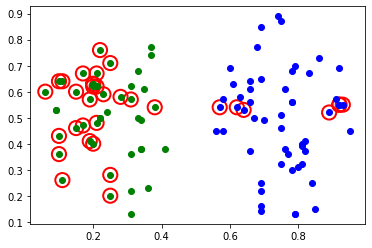

In [14]:
# evaluate model and compute accuracy
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]

print('Accuracy:', sum(y_predict == np.array(y01))/len(np.array(y01)))

# plot results
# red == wrongly classified
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=2)
plt.show()

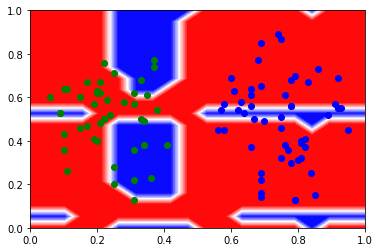

In [15]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')

X1 = np.linspace(0, 1, num=20)
Z1 = np.zeros((len(X1), len(X1)))

# Contour map
for j in range(len(X1)):
    for k in range(len(X1)):
        # Fill Z with the labels (numerical values)
        # the inner loop goes over the columns of Z,
        # which corresponds to sweeping x-values
        # Therefore, the role of j,k is flipped in the signature
        Z1[j, k] = np.argmax(model2(Tensor([X1[k],X1[j],X1[k],X1[j]])).detach().numpy())
        
plt.contourf(X1, X1, Z1, cmap='bwr', levels=30)